In [86]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import chi2_contingency
#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE


# embedded methods
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings('ignore')

1. Data preparation
2. Model training
3. Model predicting
4. Performance metrics
5. Model Comparison

# Importing the data set|

In [2]:
sample_submission = pd.read_csv('/Users/catarinasilva/Desktop/UNI/Mestrado/ML/Final Project_ML/project_data/sample_submission.csv')

In [3]:
test = pd.read_csv('/Users/catarinasilva/Desktop/UNI/Mestrado/ML/Final Project_ML/project_data/test.csv')

In [4]:
na_values_list = ['?', '']
train = pd.read_csv('/Users/catarinasilva/Desktop/UNI/Mestrado/ML/Final Project_ML/project_data/train.csv', sep=';', na_values=na_values_list)
train.head()

,encounter_id,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
0,533192,USA,70110,Caucasian,Female,[70-80),NaN,NaN,0,0,...,276,466,8,NaN,NaN,No,No,[],No,>30 days
1,426845,USA,29775006,AfricanAmerican,Male,[50-60),NaN,NaN,0,0,...,785,162,9,NaN,NaN,No,Yes,['insulin'],No,No
2,110358,USA,80729253,Caucasian,Female,[60-70),NaN,NaN,0,0,...,135,250,6,NaN,NaN,Ch,Yes,"['glimepiride', 'insulin']",No,No
3,628963,USA,2919042,AfricanAmerican,Male,[60-70),NaN,MC,0,0,...,562,455,5,NaN,NaN,No,No,[],No,No
4,130580,USA,84871971,Caucasian,Female,[70-80),NaN,HM,1,0,...,599,428,9,NaN,NaN,No,No,[],No,>30 days


# Inicial exploration

In [5]:
train.set_index('encounter_id', inplace = True)
train = pd.DataFrame(train)
train.head()

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
533192,USA,70110,Caucasian,Female,[70-80),NaN,NaN,0,0,2,...,276,466,8,NaN,NaN,No,No,[],No,>30 days
426845,USA,29775006,AfricanAmerican,Male,[50-60),NaN,NaN,0,0,0,...,785,162,9,NaN,NaN,No,Yes,['insulin'],No,No
110358,USA,80729253,Caucasian,Female,[60-70),NaN,NaN,0,0,1,...,135,250,6,NaN,NaN,Ch,Yes,"['glimepiride', 'insulin']",No,No
628963,USA,2919042,AfricanAmerican,Male,[60-70),NaN,MC,0,0,1,...,562,455,5,NaN,NaN,No,No,[],No,No
130580,USA,84871971,Caucasian,Female,[70-80),NaN,HM,1,0,0,...,599,428,9,NaN,NaN,No,No,[],No,>30 days


In [6]:
train.describe()

,patient_id,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,average_pulse_bpm,length_of_stay_in_hospital,number_lab_tests,non_lab_procedures,number_of_medications,number_diagnoses
count,7.123600e+04,71236.000000,71236.000000,71236.000000,71236.000000,71236.000000,71236.000000,71236.000000,71236.000000,71236.000000
mean,5.430228e+07,0.369588,0.196249,0.640154,99.486622,4.391024,43.095654,1.340923,15.995452,7.421023
std,3.879585e+07,1.287469,0.910854,1.267271,23.098802,2.988739,19.642919,1.706664,8.122347,1.937809
min,1.350000e+02,0.000000,0.000000,0.000000,60.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,2.339651e+07,0.000000,0.000000,0.000000,79.000000,2.000000,31.000000,0.000000,10.000000,6.000000
50%,4.530563e+07,0.000000,0.000000,0.000000,100.000000,4.000000,44.000000,1.000000,15.000000,8.000000
75%,8.755837e+07,0.000000,0.000000,1.000000,119.000000,6.000000,57.000000,2.000000,20.000000,9.000000
max,1.895026e+08,42.000000,76.000000,21.000000,139.000000,14.000000,121.000000,6.000000,75.000000,16.000000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71236 entries, 533192 to 721770
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   country                                71236 non-null  object
 1   patient_id                             71236 non-null  int64 
 2   race                                   66166 non-null  object
 3   gender                                 71236 non-null  object
 4   age                                    67679 non-null  object
 5   weight                                 2246 non-null   object
 6   payer_code                             43035 non-null  object
 7   outpatient_visits_in_previous_year     71236 non-null  int64 
 8   emergency_visits_in_previous_year      71236 non-null  int64 
 9   inpatient_visits_in_previous_year      71236 non-null  int64 
 10  admission_type                         67530 non-null  object
 11  medical_specia

In [8]:
train.dtypes

country                                  object
patient_id                                int64
race                                     object
gender                                   object
age                                      object
weight                                   object
payer_code                               object
outpatient_visits_in_previous_year        int64
emergency_visits_in_previous_year         int64
inpatient_visits_in_previous_year         int64
admission_type                           object
medical_specialty                        object
average_pulse_bpm                         int64
discharge_disposition                    object
admission_source                         object
length_of_stay_in_hospital                int64
number_lab_tests                          int64
non_lab_procedures                        int64
number_of_medications                     int64
primary_diagnosis                        object
secondary_diagnosis                     

In [9]:
train['readmitted_binary'].unique()

array(['No', 'Yes'], dtype=object)

In [10]:
train['readmitted_multiclass'].unique()

array(['>30 days', 'No', '<30 days'], dtype=object)

# Missing Values

<Axes: >

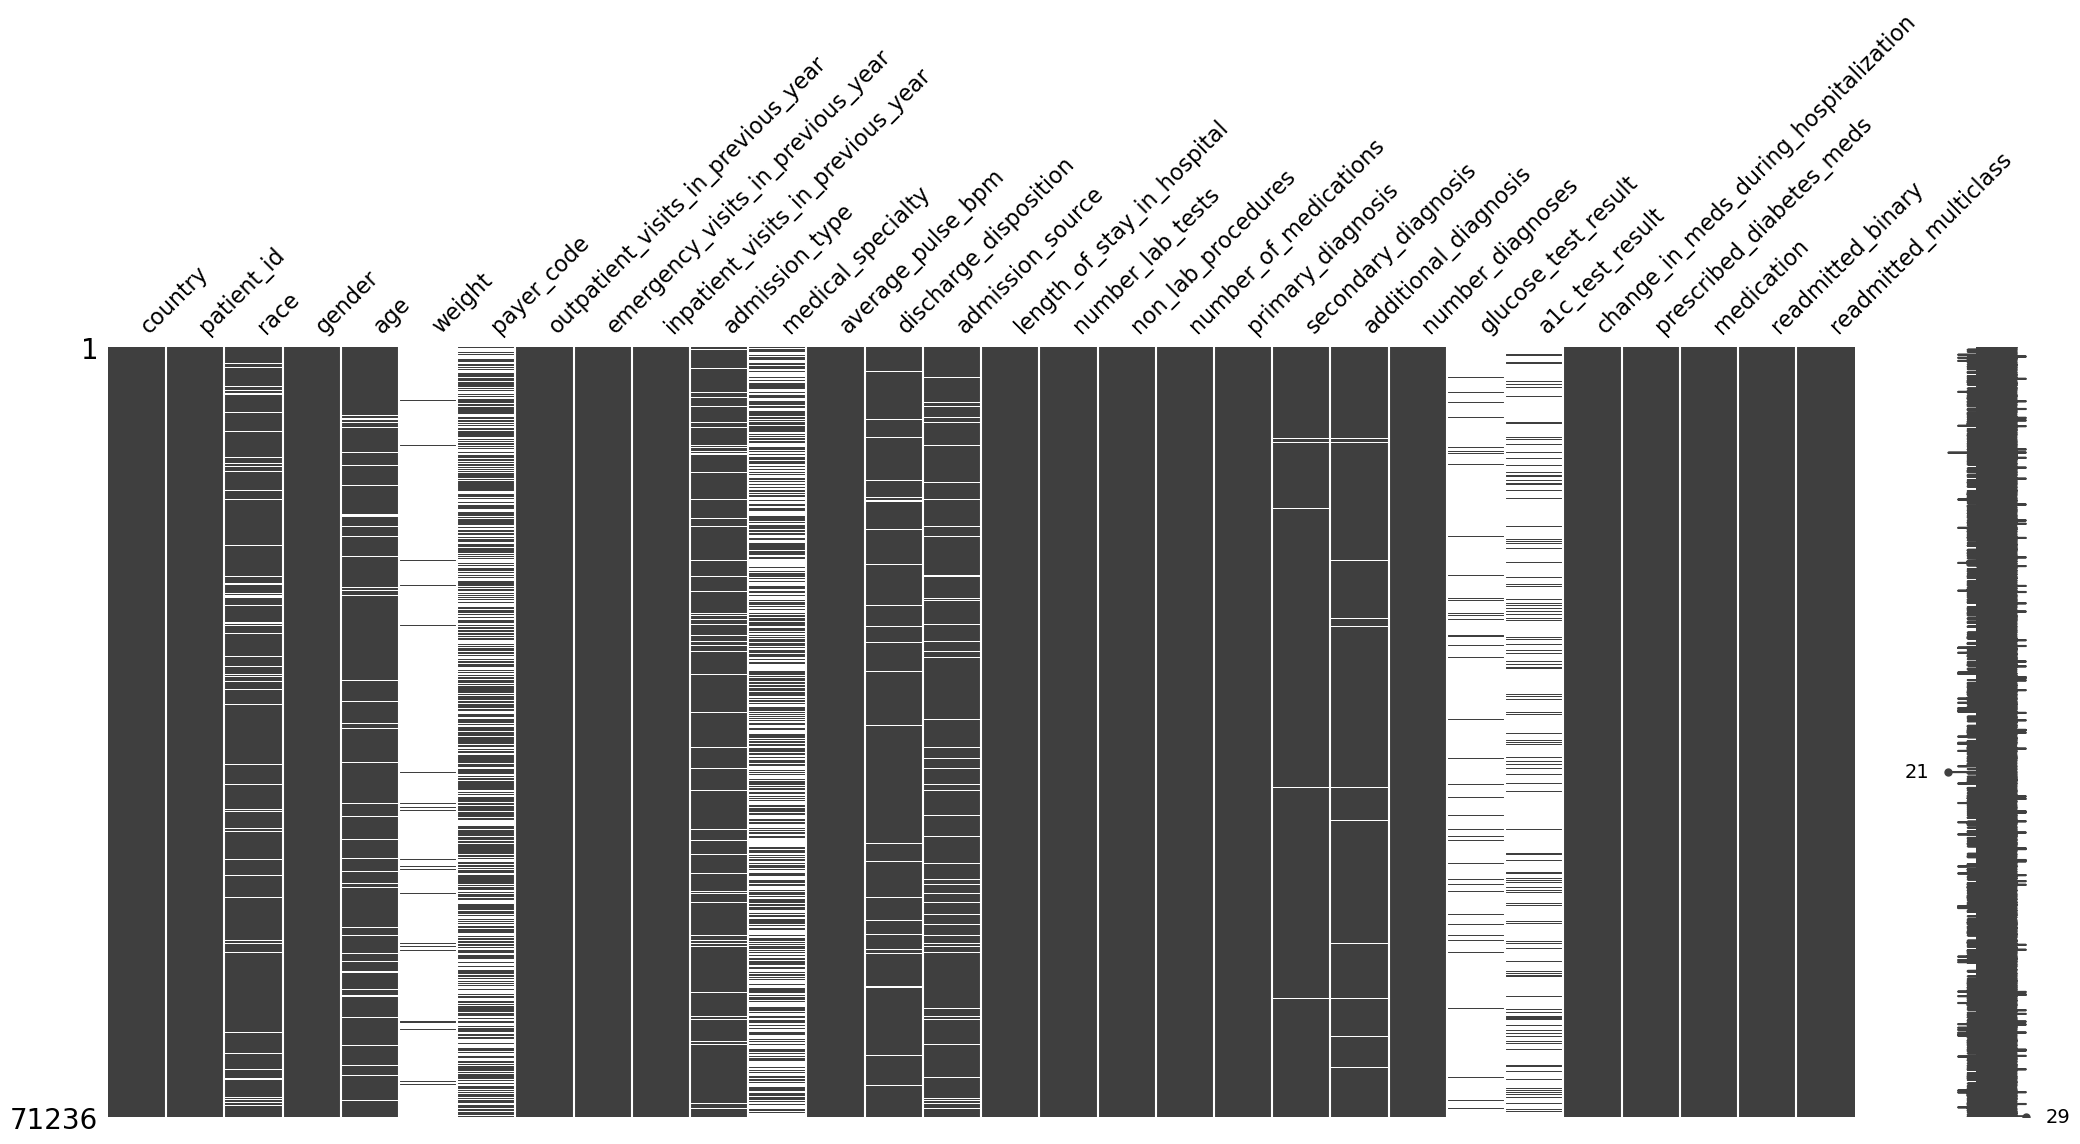

In [11]:
msno.matrix(train)

In [12]:
len(train)

71236

In [13]:
#dropping missing values that repesente less than 5% of the data 
threshold= len(train)*0.05
cols_to_drop = train.columns[train.isna().sum() <= threshold]
train.dropna(subset=cols_to_drop, inplace= True)
len(train)

64226

<Axes: >

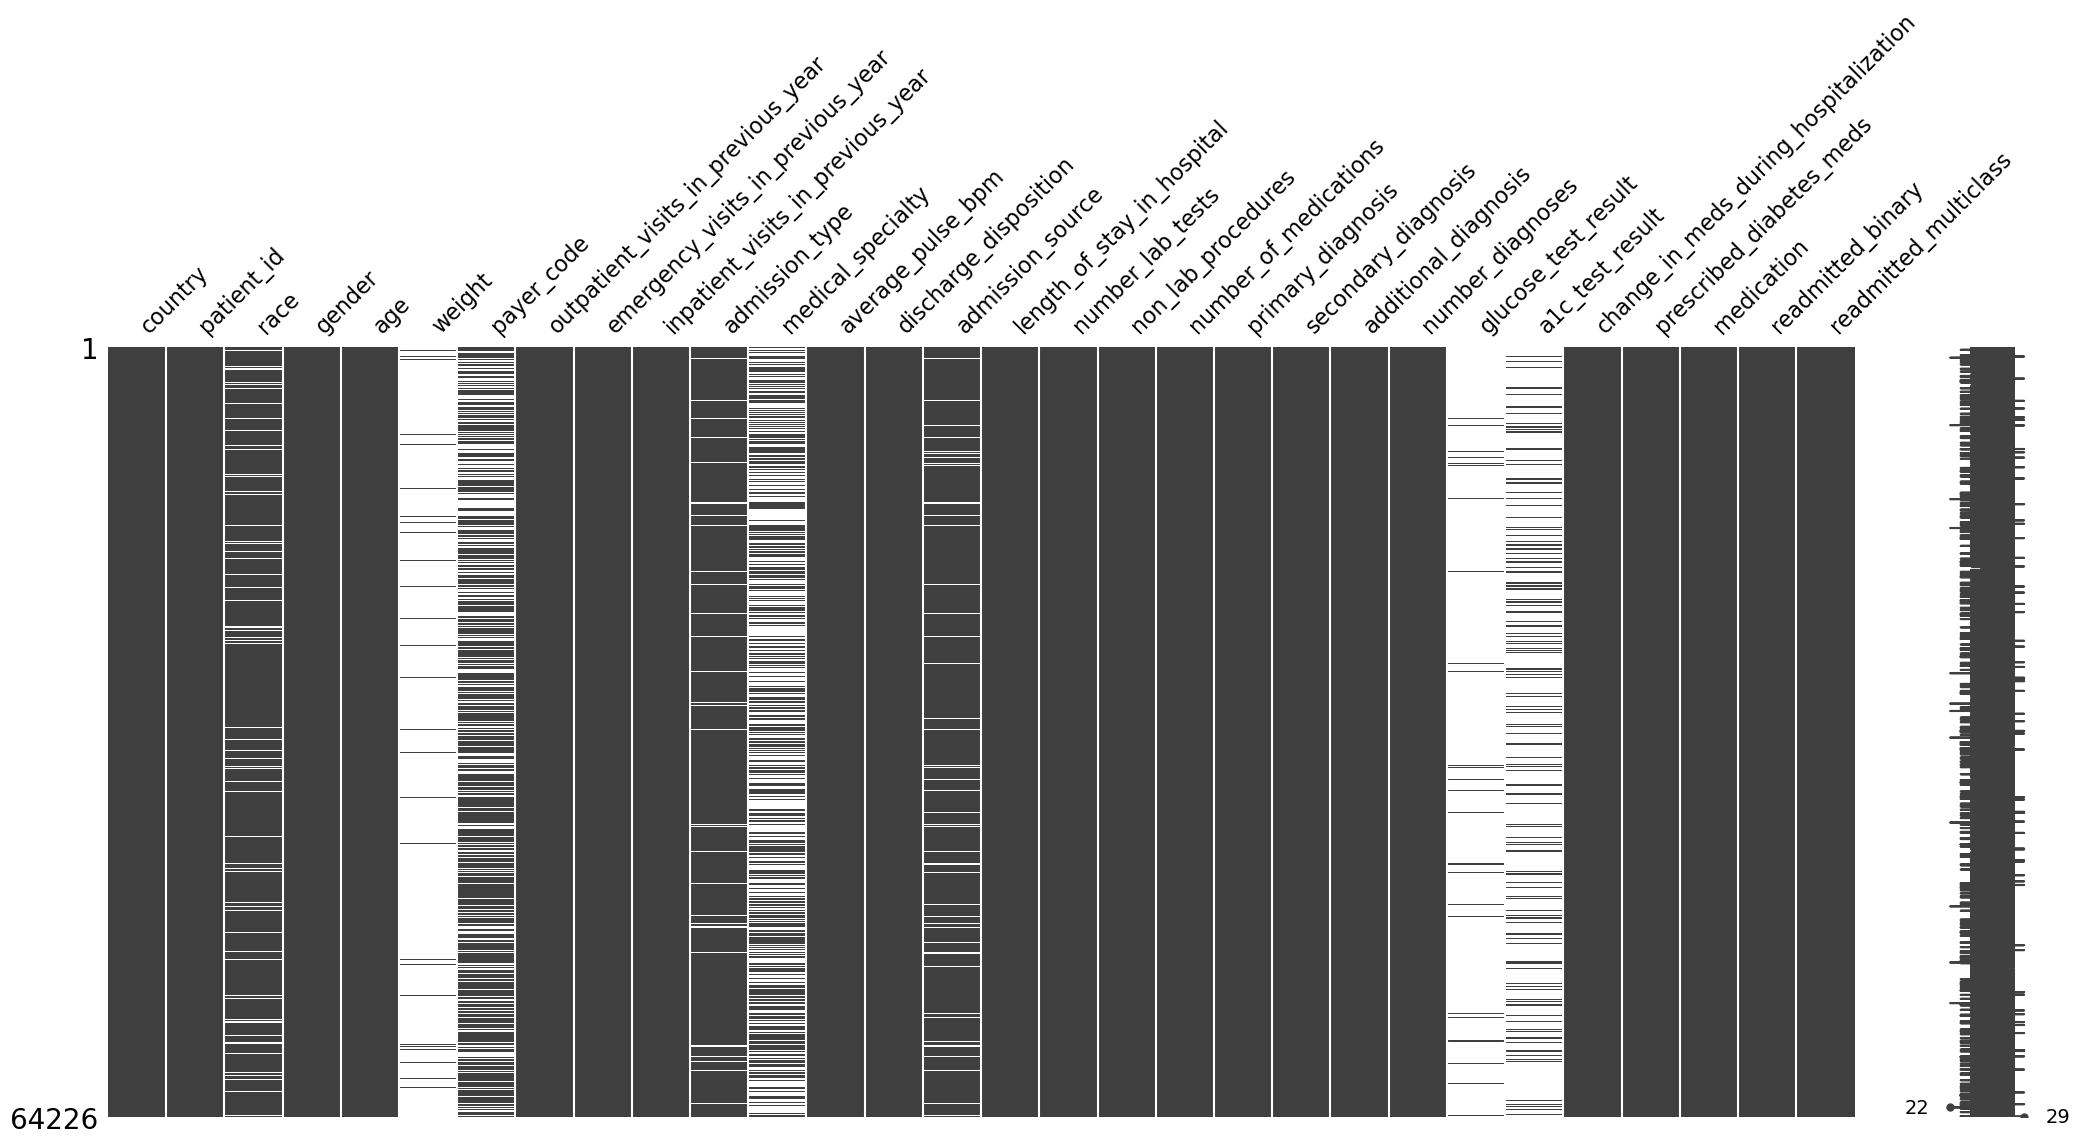

In [14]:
msno.matrix(train)

In [15]:
train.isna().sum()

country                                      0
patient_id                                   0
race                                      4620
gender                                       0
age                                          0
weight                                   62143
payer_code                               23828
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            3433
medical_specialty                        30983
average_pulse_bpm                            0
discharge_disposition                        0
admission_source                          4418
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                            0
secondary_diagnosis                          0
additional_di

# Droping columns and filling nan

In [16]:
train.drop('weight',axis=1, inplace=True)

In [17]:
print(train['country'].unique())
train.drop('country',axis=1, inplace=True)

['USA']


In [18]:
cols_missing_values= train.columns[train.isna().sum() > 0]
cols_missing_values

Index(['race', 'payer_code', 'admission_type', 'medical_specialty',
       'admission_source', 'glucose_test_result', 'a1c_test_result'],
      dtype='object')

In [19]:
train['race'].fillna('Unknown', inplace=True)
train['medical_specialty'].fillna('Unknown', inplace=True)
train['admission_source'].fillna('Unknown', inplace=True)
train['payer_code'].fillna('None', inplace=True)
train['glucose_test_result'].fillna('None', inplace=True)
train['a1c_test_result'].fillna('None', inplace=True)
train['admission_type'].fillna('Unknown', inplace=True)

In [20]:
train.isna().sum()

patient_id                               0
race                                     0
gender                                   0
age                                      0
payer_code                               0
outpatient_visits_in_previous_year       0
emergency_visits_in_previous_year        0
inpatient_visits_in_previous_year        0
admission_type                           0
medical_specialty                        0
average_pulse_bpm                        0
discharge_disposition                    0
admission_source                         0
length_of_stay_in_hospital               0
number_lab_tests                         0
non_lab_procedures                       0
number_of_medications                    0
primary_diagnosis                        0
secondary_diagnosis                      0
additional_diagnosis                     0
number_diagnoses                         0
glucose_test_result                      0
a1c_test_result                          0
change_in_m

# Categorical feautures

In [21]:
#shortening the names of the features
new_column_names = {'outpatient_visits_in_previous_year': 'outpatient_visits', 
                    'emergency_visits_in_previous_year': 'emergency_visits',
                    'inpatient_visits_in_previous_year': 'inpatient_visits',
                    'change_in_meds_during_hospitalization': 'change_in_meds',
                    'length_of_stay_in_hospital': 'length_of_stay',
                    'prescribed_diabetes_meds': 'diabetes_meds'
                   }
train = train.rename(columns=new_column_names)

In [22]:
train['race'].value_counts(normalize=True)

race
Caucasian          0.714415
AfricanAmerican    0.175396
Unknown            0.071933
Hispanic           0.018279
Other              0.013904
Asian              0.006072
Name: proportion, dtype: float64

In [23]:
replace_race = {
    'Unknown': 'Other',
    'Hispanic': 'Other',
    'Asian': 'Other'}

train['race'] = train['race'].replace(replace_race)

In [24]:
train['race'].value_counts()

race
Caucasian          45884
AfricanAmerican    11265
Other               7077
Name: count, dtype: int64

In [25]:
train['medication'].value_counts(normalize=True)

medication
['insulin']                                                               0.308660
[]                                                                        0.224411
['metformin']                                                             0.043814
['metformin', 'insulin']                                                  0.043300
['glipizide']                                                             0.038131
                                                                            ...   
['glyburide', 'insulin', 'glyburide-metformin', 'glipizide-metformin']    0.000016
['repaglinide', 'glimepiride', 'glyburide', 'insulin']                    0.000016
['metformin', 'rosiglitazone', 'tolazamide', 'insulin']                   0.000016
['metformin', 'nateglinide', 'glimepiride', 'insulin']                    0.000016
['glimepiride', 'rosiglitazone', 'miglitol', 'insulin']                   0.000016
Name: proportion, Length: 292, dtype: float64

In [26]:
train['medication'] = train['medication'].str.replace('[]', 'no medication')

In [27]:
train['medication'].value_counts(normalize=True)

medication
['insulin']                                                               0.308660
no medication                                                             0.224411
['metformin']                                                             0.043814
['metformin', 'insulin']                                                  0.043300
['glipizide']                                                             0.038131
                                                                            ...   
['glyburide', 'insulin', 'glyburide-metformin', 'glipizide-metformin']    0.000016
['repaglinide', 'glimepiride', 'glyburide', 'insulin']                    0.000016
['metformin', 'rosiglitazone', 'tolazamide', 'insulin']                   0.000016
['metformin', 'nateglinide', 'glimepiride', 'insulin']                    0.000016
['glimepiride', 'rosiglitazone', 'miglitol', 'insulin']                   0.000016
Name: proportion, Length: 292, dtype: float64

In [28]:
train['medication'] = np.where(train['medication']== 'no medication',0,1)
#no medication = 0 | medication taken=1

In [29]:
train['medication'].value_counts(normalize=True)

medication
1    0.775589
0    0.224411
Name: proportion, dtype: float64

In [30]:
#maybe use label encoder in age
train['age'].unique()

array(['[70-80)', '[50-60)', '[60-70)', '[80-90)', '[40-50)', '[20-30)',
       '[30-40)', '[90-100)', '[10-20)', '[0-10)'], dtype=object)

#assign the mid value to age
data = train['age']
df = pd.DataFrame(data)

# Extract the lower and upper age values as separate columns
df[['Lower_Age', 'Upper_Age']] = df['age'].str.extract(r'\[(\d+)-(\d+)\)')

df['Lower_Age'] = df['Lower_Age'].astype(int)
df['Upper_Age'] = df['Upper_Age'].astype(int)


df['Midpoint_Age'] = ((df['Lower_Age'] + df['Upper_Age']) / 2).astype('int')
df['Midpoint_Age']

train['Midpoint_Age'] = df['Midpoint_Age']
train.drop('age', axis=1, inplace=True)

In [31]:
train['gender_binary'] = np.where(train['gender']== 'Male',1,0)
#Female = 0 Male = 1
train.drop('gender', axis=1, inplace=True)

In [32]:
train['diabetes_meds_binary'] = np.where(train['diabetes_meds']== 'Yes',1,0)
#No = 0 Yes = 1
train.drop('diabetes_meds', axis=1, inplace=True)

In [33]:
train['change_in_meds_binary'] = np.where(train['change_in_meds']== 'Ch',1,0)
#no change = 0 change = 1
train.drop('change_in_meds', axis=1, inplace=True)

In [34]:
train.head()

,patient_id,race,age,payer_code,outpatient_visits,emergency_visits,inpatient_visits,admission_type,medical_specialty,average_pulse_bpm,...,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,medication,readmitted_binary,readmitted_multiclass,gender_binary,diabetes_meds_binary,change_in_meds_binary
encounter_id,,,,,,,,,,,,,,,,,,,,,
533192,70110,Caucasian,[70-80),None,0,0,2,Emergency,Family/GeneralPractice,86,...,466,8,None,None,0,No,>30 days,0,0,0
426845,29775006,AfricanAmerican,[50-60),None,0,0,0,Emergency,Unknown,82,...,162,9,None,None,1,No,No,1,1,0
110358,80729253,Caucasian,[60-70),None,0,0,1,Unknown,Family/GeneralPractice,88,...,250,6,None,None,1,No,No,0,1,1
628963,2919042,AfricanAmerican,[60-70),MC,0,0,1,Emergency,InternalMedicine,129,...,455,5,None,None,0,No,No,1,0,0
130580,84871971,Caucasian,[70-80),HM,1,0,0,Elective,Unknown,121,...,428,9,None,None,0,No,>30 days,0,0,0


In [35]:
n_categorical_columns= len(train.select_dtypes(exclude=np.number).columns)
categorical_columns = list(train.select_dtypes(exclude=np.number).columns)

print('There are',n_categorical_columns, 'columns with categorical values:')
print()
print(categorical_columns)

There are 14 columns with categorical values:

['race', 'age', 'payer_code', 'admission_type', 'medical_specialty', 'discharge_disposition', 'admission_source', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis', 'glucose_test_result', 'a1c_test_result', 'readmitted_binary', 'readmitted_multiclass']


In [36]:
train['payer_code'].value_counts(normalize=True)

payer_code
None    0.371002
MC      0.333448
HM      0.062747
SP      0.051381
BC      0.047691
MD      0.036185
CP      0.025379
UN      0.024959
CM      0.019961
OG      0.010712
PO      0.005901
DM      0.005403
CH      0.001495
WC      0.001401
OT      0.000903
MP      0.000779
SI      0.000638
FR      0.000016
Name: proportion, dtype: float64

In [37]:
value_counts = train['payer_code'].value_counts(normalize=True)
replace_payer_code = value_counts[value_counts < 0.10].index

train['payer_code'] = train['payer_code'].replace(replace_payer_code, 'Other')

In [38]:
train['payer_code'].value_counts(normalize=True)

payer_code
None     0.371002
MC       0.333448
Other    0.295550
Name: proportion, dtype: float64

In [39]:
train['admission_type'].value_counts(normalize=True)

admission_type
Emergency        0.527294
Urgent           0.184583
Elective         0.182667
Unknown          0.053452
Not Available    0.048610
Not Mapped       0.003114
Trauma Center    0.000187
Newborn          0.000093
Name: proportion, dtype: float64

In [40]:
value_counts = train['admission_type'].value_counts(normalize=True)
replace_admission_type = value_counts[value_counts < 0.10].index

train['admission_type'] = train['admission_type'].replace(replace_admission_type, 'Other')
train['admission_type'].value_counts(normalize=True)

admission_type
Emergency    0.527294
Urgent       0.184583
Elective     0.182667
Other        0.105456
Name: proportion, dtype: float64

In [41]:
train['medical_specialty'].value_counts(normalize=True)

medical_specialty
Unknown                         0.482406
InternalMedicine                0.149316
Emergency/Trauma                0.078286
Family/GeneralPractice          0.071669
Cardiology                      0.054947
                                  ...   
Proctology                      0.000016
DCPTEAM                         0.000016
Speech                          0.000016
Pediatrics-EmergencyMedicine    0.000016
Neurophysiology                 0.000016
Name: proportion, Length: 68, dtype: float64

In [42]:
value_counts = train['medical_specialty'].value_counts(normalize=True)
replace_medical_specialty = value_counts[value_counts < 0.05].index

train['medical_specialty'] = train['medical_specialty'].replace('Unknown', 'Other')

train['medical_specialty'] = train['medical_specialty'].replace(replace_medical_specialty, 'Other')

train['medical_specialty'].value_counts(normalize=True)

medical_specialty
Other                     0.645782
InternalMedicine          0.149316
Emergency/Trauma          0.078286
Family/GeneralPractice    0.071669
Cardiology                0.054947
Name: proportion, dtype: float64

In [43]:
train['discharge_disposition'].value_counts(normalize=True)

discharge_disposition
Discharged to home                                                                                           0.611637
Discharged/transferred to SNF                                                                                0.144521
Discharged/transferred to home with home health service                                                      0.132485
Discharged/transferred to another short term hospital                                                        0.021985
Discharged/transferred to another rehab fac including rehab units of a hospital .                            0.020288
Expired                                                                                                      0.016847
Discharged/transferred to another type of inpatient care institution                                         0.012036
Not Mapped                                                                                                   0.009700
Discharged/transferred to ICF     

In [44]:
value_counts = train['discharge_disposition'].value_counts(normalize=True)
replace_discharge_disposition = value_counts[value_counts < 0.05].index

train['discharge_disposition'] = train['discharge_disposition'].replace(replace_discharge_disposition, 'Other')

train['discharge_disposition'].value_counts(normalize=True)

discharge_disposition
Discharged to home                                         0.611637
Discharged/transferred to SNF                              0.144521
Discharged/transferred to home with home health service    0.132485
Other                                                      0.111357
Name: proportion, dtype: float64

In [45]:
train['admission_source'].value_counts(normalize=True)

admission_source
 Emergency Room                                               0.567854
 Physician Referral                                           0.291331
Unknown                                                       0.068788
Transfer from a hospital                                      0.027699
 Transfer from another health care facility                   0.021611
Clinic Referral                                               0.010525
 Transfer from a Skilled Nursing Facility (SNF)               0.007910
 Not Mapped                                                   0.001619
 Not Available                                                0.001199
HMO Referral                                                  0.000981
 Court/Law Enforcement                                        0.000171
 Transfer from hospital inpt/same fac reslt in a sep claim    0.000125
 Transfer from critial access hospital                        0.000109
 Transfer from Ambulatory Surgery Center                    

In [46]:
value_counts = train['admission_source'].value_counts(normalize=True)
replace_admission_source = value_counts[value_counts < 0.05].index

train['admission_source'] = train['admission_source'].replace(replace_admission_source, 'Other')
train['admission_source'] = train['admission_source'].replace('Unknown', 'Other')

train['admission_source'].value_counts(normalize=True)

admission_source
 Emergency Room        0.567854
 Physician Referral    0.291331
Other                  0.140815
Name: proportion, dtype: float64

In [47]:
train['primary_diagnosis'].value_counts(normalize=True)

primary_diagnosis
428    0.067558
414    0.063806
786    0.039205
486    0.035671
410    0.034799
         ...   
582    0.000016
906    0.000016
868    0.000016
366    0.000016
299    0.000016
Name: proportion, Length: 676, dtype: float64

In [48]:
value_counts = train['primary_diagnosis'].value_counts(normalize=True)
replace_primary_diagnosis = value_counts[value_counts < 0.05].index

train['primary_diagnosis'] = train['primary_diagnosis'].replace(replace_primary_diagnosis, 'Other')


train['primary_diagnosis'].value_counts(normalize=True)

primary_diagnosis
Other    0.868636
428      0.067558
414      0.063806
Name: proportion, dtype: float64

In [49]:
train['secondary_diagnosis'].value_counts(normalize=True)

secondary_diagnosis
276     0.066904
428     0.065846
250     0.055071
427     0.049949
401     0.037010
          ...   
944     0.000016
7       0.000016
814     0.000016
529     0.000016
E968    0.000016
Name: proportion, Length: 688, dtype: float64

In [50]:
value_counts = train['secondary_diagnosis'].value_counts(normalize=True)
replace_secondary_diagnosis = value_counts[value_counts < 0.05].index

train['secondary_diagnosis'] = train['secondary_diagnosis'].replace(replace_secondary_diagnosis, 'Other')


train['secondary_diagnosis'].value_counts(normalize=True)

secondary_diagnosis
Other    0.812179
276      0.066904
428      0.065846
250      0.055071
Name: proportion, dtype: float64

In [51]:
train['additional_diagnosis'].value_counts(normalize=True)

additional_diagnosis
250       0.113661
401       0.081353
276       0.052673
428       0.046056
427       0.039579
            ...   
115       0.000016
250.23    0.000016
E965      0.000016
911       0.000016
669       0.000016
Name: proportion, Length: 736, dtype: float64

In [52]:
value_counts = train['additional_diagnosis'].value_counts(normalize=True)
replace_additional_diagnosis = value_counts[value_counts < 0.05].index

train['additional_diagnosis'] = train['additional_diagnosis'].replace(replace_additional_diagnosis, 'Other')


train['additional_diagnosis'].value_counts(normalize=True)

additional_diagnosis
Other    0.752312
250      0.113661
401      0.081353
276      0.052673
Name: proportion, dtype: float64

In [53]:
train['glucose_test_result'].value_counts(normalize=True)

glucose_test_result
None    0.946408
Norm    0.026391
>200    0.015445
>300    0.011755
Name: proportion, dtype: float64

In [54]:
train['a1c_test_result'].value_counts(normalize=True)

a1c_test_result
None    0.834973
>8      0.077399
Norm    0.049404
>7      0.038224
Name: proportion, dtype: float64

In [55]:
#perguntar se posso remover linhas, e se so devo tirar o target depois de limpar os dados todos
target_binary = train['readmitted_binary']
target_binary = np.where(train['readmitted_binary']== 'No',0,1)
target_binary = pd.DataFrame(target_binary)

target_multiclass = train['readmitted_multiclass']  

train.drop(['readmitted_binary','readmitted_multiclass'], axis=1, inplace=True)

In [56]:
train.head()

,patient_id,race,age,payer_code,outpatient_visits,emergency_visits,inpatient_visits,admission_type,medical_specialty,average_pulse_bpm,...,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,medication,gender_binary,diabetes_meds_binary,change_in_meds_binary
encounter_id,,,,,,,,,,,,,,,,,,,,,
533192,70110,Caucasian,[70-80),None,0,0,2,Emergency,Family/GeneralPractice,86,...,Other,276,Other,8,None,None,0,0,0,0
426845,29775006,AfricanAmerican,[50-60),None,0,0,0,Emergency,Other,82,...,Other,Other,Other,9,None,None,1,1,1,0
110358,80729253,Caucasian,[60-70),None,0,0,1,Other,Family/GeneralPractice,88,...,Other,Other,250,6,None,None,1,0,1,1
628963,2919042,AfricanAmerican,[60-70),MC,0,0,1,Emergency,InternalMedicine,129,...,Other,Other,Other,5,None,None,0,1,0,0
130580,84871971,Caucasian,[70-80),Other,1,0,0,Elective,Other,121,...,Other,Other,Other,9,None,None,0,0,0,0


# Encoding categorical data

In [57]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(train['age'])
train['age'] = label_encoder.transform(train['age'])
train

,patient_id,race,age,payer_code,outpatient_visits,emergency_visits,inpatient_visits,admission_type,medical_specialty,average_pulse_bpm,...,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,medication,gender_binary,diabetes_meds_binary,change_in_meds_binary
encounter_id,,,,,,,,,,,,,,,,,,,,,
533192,70110,Caucasian,7,None,0,0,2,Emergency,Family/GeneralPractice,86,...,Other,276,Other,8,None,None,0,0,0,0
426845,29775006,AfricanAmerican,5,None,0,0,0,Emergency,Other,82,...,Other,Other,Other,9,None,None,1,1,1,0
110358,80729253,Caucasian,6,None,0,0,1,Other,Family/GeneralPractice,88,...,Other,Other,250,6,None,None,1,0,1,1
628963,2919042,AfricanAmerican,6,MC,0,0,1,Emergency,InternalMedicine,129,...,Other,Other,Other,5,None,None,0,1,0,0
130580,84871971,Caucasian,7,Other,1,0,0,Elective,Other,121,...,Other,Other,Other,9,None,None,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495864,65777877,Caucasian,7,MC,3,1,1,Emergency,Other,106,...,Other,Other,Other,9,None,None,1,0,1,1
136517,24531381,AfricanAmerican,8,MC,0,1,0,Elective,InternalMedicine,108,...,Other,Other,250,9,None,>7,1,0,1,1
332023,23397147,Caucasian,6,None,0,2,2,Other,Other,71,...,428,Other,276,9,>300,None,1,0,1,1


In [58]:
from sklearn.preprocessing import OrdinalEncoder
enc1 = OrdinalEncoder() 

In [59]:
numerical_columns = train.select_dtypes(include=np.number).columns
categorical_columns = pd.DataFrame(train.drop(numerical_columns, axis=1))

In [60]:
enc1.fit(categorical_columns)
train_encoded = pd.DataFrame(enc1.transform(categorical_columns), columns = categorical_columns.columns)
train_encoded.set_index(train.index, inplace=True)
train_encoded

,race,payer_code,admission_type,medical_specialty,discharge_disposition,admission_source,primary_diagnosis,secondary_diagnosis,additional_diagnosis,glucose_test_result,a1c_test_result
encounter_id,,,,,,,,,,,
533192,1.0,1.0,1.0,2.0,0.0,0.0,2.0,1.0,3.0,2.0,2.0
426845,0.0,1.0,1.0,4.0,3.0,2.0,2.0,3.0,3.0,2.0,2.0
110358,1.0,1.0,2.0,2.0,0.0,2.0,2.0,3.0,0.0,2.0,2.0
628963,0.0,0.0,1.0,3.0,0.0,2.0,2.0,3.0,3.0,2.0,2.0
130580,1.0,2.0,0.0,4.0,2.0,1.0,2.0,3.0,3.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
495864,1.0,0.0,1.0,4.0,1.0,0.0,2.0,3.0,3.0,2.0,2.0
136517,0.0,0.0,0.0,3.0,0.0,1.0,2.0,3.0,0.0,2.0,0.0
332023,1.0,1.0,2.0,4.0,3.0,2.0,1.0,3.0,1.0,1.0,2.0


In [61]:
train.drop(categorical_columns, axis=1, inplace=True)
train

,patient_id,age,outpatient_visits,emergency_visits,inpatient_visits,average_pulse_bpm,length_of_stay,number_lab_tests,non_lab_procedures,number_of_medications,number_diagnoses,medication,gender_binary,diabetes_meds_binary,change_in_meds_binary
encounter_id,,,,,,,,,,,,,,,
533192,70110,7,0,0,2,86,2,48,0,20,8,0,0,0,0
426845,29775006,5,0,0,0,82,14,71,0,25,9,1,1,1,0
110358,80729253,6,0,0,1,88,6,60,1,22,6,1,0,1,1
628963,2919042,6,0,0,1,129,6,48,2,9,5,0,1,0,0
130580,84871971,7,1,0,0,121,6,47,1,15,9,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495864,65777877,7,3,1,1,106,4,57,0,26,9,1,0,1,1
136517,24531381,8,0,1,0,108,7,51,1,18,9,1,0,1,1
332023,23397147,6,0,2,2,71,5,25,0,24,9,1,0,1,1


In [69]:
train_allnumeric = train.join(train_encoded)
train_allnumeric

,patient_id,age,outpatient_visits,emergency_visits,inpatient_visits,average_pulse_bpm,length_of_stay,number_lab_tests,non_lab_procedures,number_of_medications,...,payer_code,admission_type,medical_specialty,discharge_disposition,admission_source,primary_diagnosis,secondary_diagnosis,additional_diagnosis,glucose_test_result,a1c_test_result
encounter_id,,,,,,,,,,,,,,,,,,,,,
533192,70110,7,0,0,2,86,2,48,0,20,...,1.0,1.0,2.0,0.0,0.0,2.0,1.0,3.0,2.0,2.0
426845,29775006,5,0,0,0,82,14,71,0,25,...,1.0,1.0,4.0,3.0,2.0,2.0,3.0,3.0,2.0,2.0
110358,80729253,6,0,0,1,88,6,60,1,22,...,1.0,2.0,2.0,0.0,2.0,2.0,3.0,0.0,2.0,2.0
628963,2919042,6,0,0,1,129,6,48,2,9,...,0.0,1.0,3.0,0.0,2.0,2.0,3.0,3.0,2.0,2.0
130580,84871971,7,1,0,0,121,6,47,1,15,...,2.0,0.0,4.0,2.0,1.0,2.0,3.0,3.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495864,65777877,7,3,1,1,106,4,57,0,26,...,0.0,1.0,4.0,1.0,0.0,2.0,3.0,3.0,2.0,2.0
136517,24531381,8,0,1,0,108,7,51,1,18,...,0.0,0.0,3.0,0.0,1.0,2.0,3.0,0.0,2.0,0.0
332023,23397147,6,0,2,2,71,5,25,0,24,...,1.0,2.0,4.0,3.0,2.0,1.0,3.0,1.0,1.0,2.0


In [70]:
train_allnumeric.dtypes

patient_id                 int64
age                        int64
outpatient_visits          int64
emergency_visits           int64
inpatient_visits           int64
average_pulse_bpm          int64
length_of_stay             int64
number_lab_tests           int64
non_lab_procedures         int64
number_of_medications      int64
number_diagnoses           int64
medication                 int64
gender_binary              int64
diabetes_meds_binary       int64
change_in_meds_binary      int64
race                     float64
payer_code               float64
admission_type           float64
medical_specialty        float64
discharge_disposition    float64
admission_source         float64
primary_diagnosis        float64
secondary_diagnosis      float64
additional_diagnosis     float64
glucose_test_result      float64
a1c_test_result          float64
dtype: object

Data ending - categorical to nmerical
scale data 
the split

# Spliting the data - Binary

In [71]:
X_train, X_val, y_train, y_val = train_test_split(train_allnumeric,target_binary, 
                                                  test_size = 0.3, 
                                                  random_state = 0, 
                                                  stratify = target_binary, 
                                                  shuffle = True)

# Scaling

In [101]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_minmax = scaler.fit(X_train,y_train)

minmax_X_train = scaled.transform(X_train)

minmax_X_val = scaled.transform(X_val)

In [74]:
from sklearn.preprocessing import RobustScaler 

scaler = RobustScaler()

scaled_robust = scaler.fit(X_train,y_train)

robust_X_train = scaled.transform(X_train)

robust_X_val = scaled.transform(X_val)

# Wrapper methods - RFE 

In [75]:
logreg = LogisticRegression()

In [77]:
logreg.fit(X_train, y_train)

/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [79]:
labels_train = logreg.predict(X_train)
labels_val = logreg.predict(X_val)

In [81]:
logreg.predict_proba(X_val)

array([[0.51080704, 0.48919296],
       [0.95373256, 0.04626744],
       [0.84992986, 0.15007014],
       ...,
       [0.7509851 , 0.2490149 ],
       [0.74516872, 0.25483128],
       [0.54601976, 0.45398024]])

In [82]:
print(logreg.score(X_train, y_train))
print(logreg.score(X_val, y_val))

0.888229013746163
0.8882603280049823


In [91]:
#no of features
nof_list=np.arange(1,8)            
high_score=0
#Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    model = LogisticRegression()
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_val_rfe = rfe.transform(X_val)
    model.fit(X_train_rfe,y_train)
    
    #storing results on training data
    train_score = model.score(X_train_rfe,y_train)
    train_score_list.append(train_score)
    
    #storing results on training data
    val_score = model.score(X_val_rfe,y_val)
    val_score_list.append(val_score)
    
    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]
        
        #adding mention of variables to keep
        features_to_select = pd.Series(rfe.support_, index = X_train.columns)
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

Optimum number of features: 7
Score with 7 features: 0.888260
Features to select: 
patient_id                True
age                       True
outpatient_visits        False
emergency_visits         False
inpatient_visits         False
average_pulse_bpm         True
length_of_stay            True
number_lab_tests          True
non_lab_procedures       False
number_of_medications     True
number_diagnoses          True
medication               False
gender_binary            False
diabetes_meds_binary     False
change_in_meds_binary    False
race                     False
payer_code               False
admission_type           False
medical_specialty        False
discharge_disposition    False
admission_source         False
primary_diagnosis        False
secondary_diagnosis      False
additional_diagnosis     False
glucose_test_result      False
a1c_test_result          False
dtype: bool


# Embedded methods - Lasso

In [92]:
reg = LassoCV()

In [93]:
reg.fit(X_train, y_train)

LassoCV()

In [94]:
coef = pd.Series(reg.coef_, index = X_train.columns)
coef.sort_values()

gender_binary           -0.000000e+00
additional_diagnosis     0.000000e+00
secondary_diagnosis      0.000000e+00
primary_diagnosis        0.000000e+00
admission_source        -0.000000e+00
discharge_disposition    0.000000e+00
medical_specialty        0.000000e+00
admission_type           0.000000e+00
payer_code              -0.000000e+00
race                    -0.000000e+00
change_in_meds_binary    0.000000e+00
diabetes_meds_binary     0.000000e+00
a1c_test_result          0.000000e+00
medication               0.000000e+00
number_diagnoses         0.000000e+00
number_of_medications    0.000000e+00
non_lab_procedures      -0.000000e+00
number_lab_tests         0.000000e+00
length_of_stay           0.000000e+00
average_pulse_bpm        0.000000e+00
inpatient_visits         0.000000e+00
emergency_visits         0.000000e+00
outpatient_visits        0.000000e+00
age                      0.000000e+00
glucose_test_result     -0.000000e+00
patient_id               6.312496e-11
dtype: float

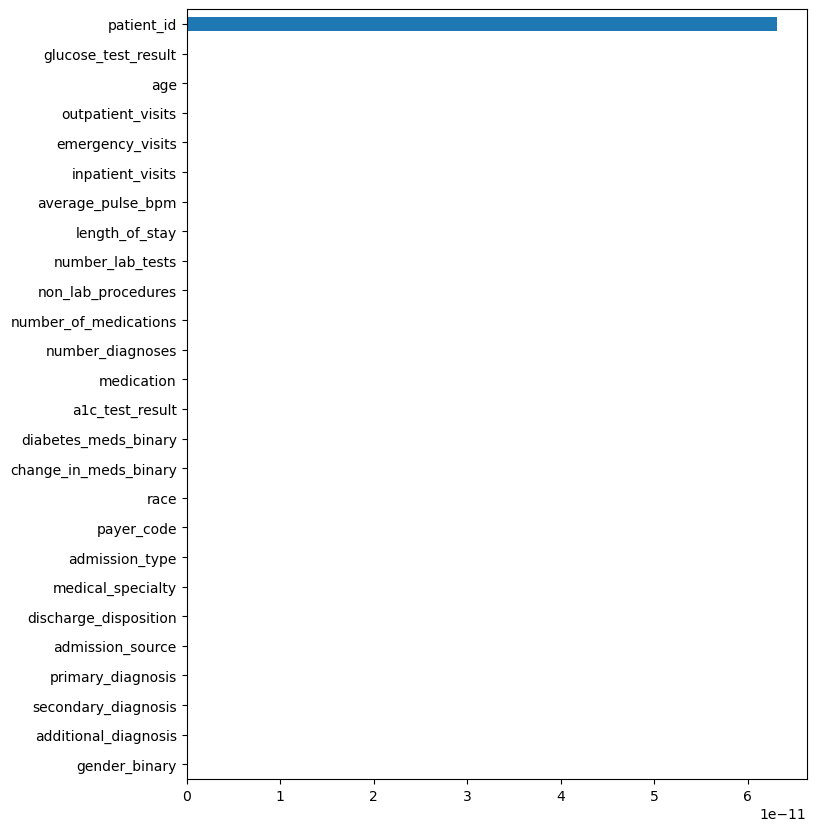

In [95]:
imp_coef = coef.sort_values()
plt.figure(figsize=(8,10))
imp_coef.plot(kind = "barh")
plt.show()

# Evaluating mutiple models at once

In [96]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression

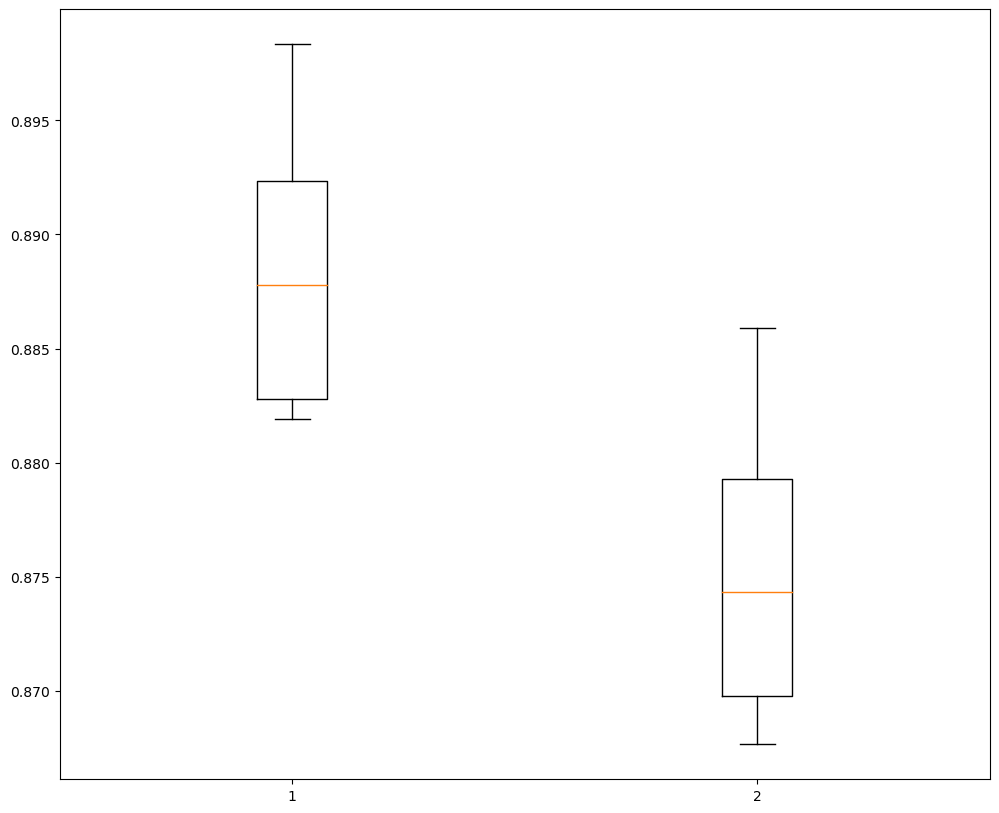

In [106]:
models = {'Logistic Regression': LogisticRegression(), 'KNN': KNeighborsClassifier()}

results = []


for model in models.values():
    kf = KFold(n_splits =10, random_state=42, shuffle=True)
    cv_results= cross_val_score(model, X_train, y_train, cv=kf)
    results.append(cv_results)

plt.figure(figsize=(12,10))
plt.boxplot(results)
plt.show()

# Encoding - target multiclass

In [88]:
from sklearn.preprocessing import OrdinalEncoder
enc2 = OrdinalEncoder() 

In [89]:
enc2.fit(train)

OrdinalEncoder()

In [90]:
target_multiclass = np.array(target_multiclass)
target_multiclass = target_multiclass.reshape(-1,1)
target_multiclass = enc1.fit_transform(target_multiclass)
target_multiclass

array([[1.],
       [2.],
       [2.],
       ...,
       [0.],
       [2.],
       [1.]])